## Machine Leaning using Rdkit descriptors:

In [1]:

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score)

from random import randint


In [2]:

#dataset after cleaning
db = pd.read_csv('../../datasets/processed/datasetRdkitDescriptors.csv')

#dataset wo outliers
#db = pd.read_csv('../../datasets/processed/datasetRdkitDescriptors_v2.csv')


In [3]:

excluded_columns_names = ['molindx', 'logS']
target_vars = 'logS'

data_new = db.sample(frac=1)
number_of_training = 20


In [4]:

rnd_state = randint(1, 1000)
train_set, test_set = train_test_split(data_new,
                                       shuffle=True,
                                       random_state=rnd_state,
                                       test_size=0.15)

X_train = train_set.drop(columns=excluded_columns_names).to_numpy()
y_train = train_set[target_vars]

X_test = test_set.drop(columns=excluded_columns_names).to_numpy()
y_test = test_set[target_vars]

#RF hyperparameters optimization
model = RandomForestRegressor(oob_score=False, random_state = rnd_state)

n_estimators = range(500, 1001, 50)
max_features = np.arange(0.1, 0.99, 0.21)
min_samples_leaf = [2] #[2,3,4]
min_samples_split = [2] #[2,3,4]

parameters = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'min_samples_leaf' : min_samples_leaf,
              'min_samples_split' : min_samples_split,
             }

#gridsearch cross-validation for model's parameter optimization
rfr = GridSearchCV(model,
                   parameters,
                   cv=10,
                   verbose=1,
                   n_jobs=2,
                   scoring='neg_mean_squared_error')

rfr.fit(X_train, y_train.values.ravel())

model = rfr.best_estimator_
print('Best Model:', model)

y_pred = model.predict(X_test)

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)


print(f'Mean Absolute Error: {mae:.2f} (mg/L)')
print(f'Mean Squared Error: {mse:.2f} (mg/L)$^{2}$')
print(f'Root Mean Squared Error: {rmse:.2f} (mg/L)')
print(f'R² Score: {r2:.2f}')


Fitting 10 folds for each of 55 candidates, totalling 550 fits
Best Model: RandomForestRegressor(max_features=0.31, min_samples_leaf=2, n_estimators=1000,
                      random_state=884)
Mean Absolute Error: 1.47 (mg/L)
Mean Squared Error: 4.23 (mg/L)$^2$
Root Mean Squared Error: 2.06 (mg/L)
R² Score: 0.83


In [5]:

n_estimators = model.n_estimators
max_features = model.max_features


In [6]:

r2_list = []
mae_list = []
rmse_list = []

for nof_training in range(number_of_training):
    rnd_state = randint(1, 1000)
    train_set, test_set = train_test_split(data_new,
                                           shuffle=True,
                                           random_state=rnd_state,
                                           test_size=0.15)

    X_train = train_set.drop(columns=excluded_columns_names).to_numpy()
    y_train = train_set[target_vars]

    X_test = test_set.drop(columns=excluded_columns_names).to_numpy()
    y_test = test_set[target_vars]
    
    #RF hyperparameters optimization
    rfr_model = RandomForestRegressor(oob_score=False,
                                      n_estimators=n_estimators,
                                      max_features=max_features,
                                      random_state = rnd_state)

    rfr_model.fit(X_train, y_train.values.ravel())

    y_pred = rfr_model.predict(X_test)

    # Calculate the MAE
    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)

    r2 = r2_score(y_test, y_pred)
    r2_list.append(r2)

mean_mae = np.mean(mae_list)
std_mae = np.std(mae_list)

mean_rmse = np.mean(rmse_list)
std_rmse = np.std(rmse_list)

mean_r2 = np.mean(r2_list)
std_r2 = np.std(r2_list)

print(f'Mean Absolute Error: {mean_mae:.2f} (mg/L) and std of MAE: {std_mae:.2f} (mg/L)')
print(f'Root Mean Squared Error: {mean_rmse:.2f} (mg/L) and std of RMSE: {std_rmse:.2f} (mg/L)')
print(f'R² Score: {mean_r2:.2f} and std of r2: {std_r2:.2f} (mg/L)')


Mean Absolute Error: 1.49 (mg/L) and std of MAE: 0.04 (mg/L)
Root Mean Squared Error: 2.15 (mg/L) and std of RMSE: 0.10 (mg/L)
R² Score: 0.79 and std of r2: 0.02 (mg/L)


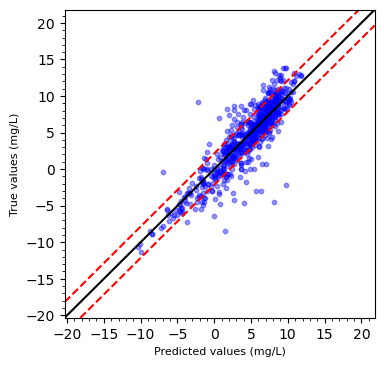

In [7]:

#sctter plot
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(y_pred, np.array(y_test), s=10, c='blue', facecolor='none', alpha=0.4)

ax.set_xlabel('Predicted values (mg/L)', fontsize=8)
ax.set_ylabel('True values (mg/L)', fontsize=8)

ymin = min(y_pred) - 10
ymax = max(y_pred) + 10
ngrids = 100
y_x = np.linspace(ymin, ymax, ngrids) 

ax.xaxis.set_major_locator(MultipleLocator(5))  
ax.yaxis.set_major_locator(MultipleLocator(5)) 

ax.xaxis.set_minor_locator(MultipleLocator(1))  
ax.yaxis.set_minor_locator(MultipleLocator(1))

stdVal = np.ones(ngrids) * np.std(y_test - y_pred)

plt.plot(y_x, y_x, 'k-')
plt.plot(y_x, y_x + stdVal, 'r--')
plt.plot(y_x, y_x - stdVal, 'r--')

plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)

plt.show()
plt.close()


In [8]:

importances = rfr_model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]


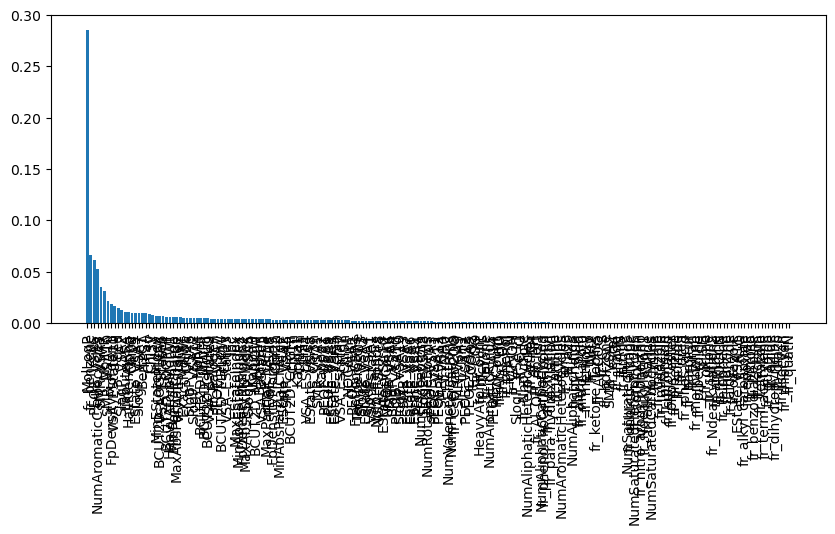

In [9]:

plt.figure(figsize=(10,4))
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]),
           data_new.drop(excluded_columns_names, axis=1).columns[sorted_indices],
           rotation=90)
plt.show()
plt.close()


In [10]:

n_most_importants = 6
print(f'Name of {n_most_importants} most important features:')
feature_names = data_new.drop(excluded_columns_names,
                              axis=1).columns[sorted_indices[:n_most_importants]]
feature_names


Name of 6 most important features:


Index(['MolLogP', 'fr_benzene', 'PEOE_VSA6', 'NumAromaticCarbocycles',
       'SMR_VSA7', 'MolMR'],
      dtype='object')

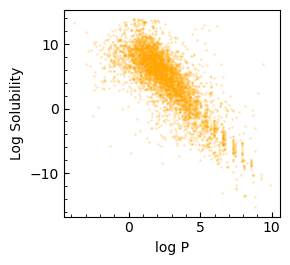

In [11]:

color='ORANGE'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

fig, ax = plt.subplots(figsize=(3.0, 2.75))

ax.scatter(db['MolLogP'], db['logS'], c=color, marker='o', facecolor='none', linewidth=0, s=3, alpha=0.3)

ax.set_xlabel('log P', fontsize=10)
ax.set_ylabel('Log Solubility', fontsize=10)

ax.yaxis.set_major_locator(MultipleLocator(10)) 
ax.yaxis.set_minor_locator(MultipleLocator(2))

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))  


plt.tight_layout()
#plt.savefig('fig_logP_vs_logS.png', dpi=600)
plt.show()
plt.close()
